In [1]:
import time

start_time = time.time()

In [2]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras import backend as k
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


In [3]:
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row
RESIZE_DIM=32 # images resized to 32x32 pixels

In [4]:
data_dir=os.path.join('Numta')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [5]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 32x32
        
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        
        X.append(img) # expand image to 32x32x1 and append to the list
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y
        
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [6]:
# get training data
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [7]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
Y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)

In [8]:
X_show_all=X_train_all

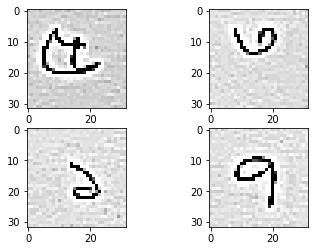

In [9]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

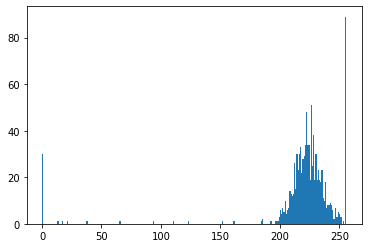

In [10]:
imgg=X_train_all[1]
hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
plt.hist(imgg.ravel(),256,[0,256])
# show Histogram
plt.show()

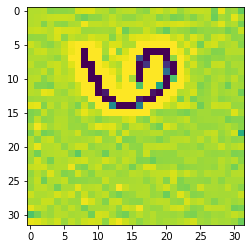

In [11]:
plt.imshow(X_train_all[1])

In [12]:
# Normalization -> range 0-1
X_train_all = X_train_all/255
Y_train_all = Y_train_all/255
# integer array to float
X_train_all = X_train_all.astype('float32')
Y_train_all = Y_train_all.astype('float32')

# Split the train and the validation set for the fitting
random_seed=42
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all,
                                  Y_train_all, 
                                  test_size = 0.1,
                                  random_state=random_seed,
                                  shuffle=True)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((64840, 32, 32), (64840, 10), (7205, 32, 32), (7205, 10))

In [13]:
# reshaping array
X_train = X_train.reshape(X_train.shape[0],32, 32,1)
X_val = X_val.reshape(X_val.shape[0],32, 32,1)

In [14]:
# defining model
def my_model(img_size=32,channels=1):
    model = Sequential()
    input_shape = (img_size,img_size,channels)
    model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model

In [15]:
model = my_model() # create the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
__________

In [16]:
path_model='model_filter_v2.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=Y_train, 
            batch_size=64, 
            epochs=20,
            verbose=1, 
            validation_data=(X_val,Y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 64840 samples, validate on 7205 samples
Epoch 1/20
64840/64840 [==============================] - 42s 655us/step - loss: 0.0050 - acc: 0.5273 - val_loss: 0.0198 - val_acc: 0.4390
Epoch 2/20
64840/64840 [==============================] - 39s 608us/step - loss: 6.0389e-04 - acc: 0.9565 - val_loss: 0.0010 - val_acc: 0.9299
Epoch 3/20
64840/64840 [==============================] - 39s 604us/step - loss: 4.0535e-04 - acc: 0.9718 - val_loss: 4.6001e-04 - val_acc: 0.9650
Epoch 4/20
64840/64840 [==============================] - 39s 605us/step - loss: 2.9517e-04 - acc: 0.9786 - val_loss: 3.7052e-04 - val_acc: 0.9770
Epoch 5/20
64840/64840 [==============================] - 39s 607us/step - loss: 2.6605e-04 - acc: 0.9814 - val_loss: 3.2068e-04 - val_acc: 0.9810
Epoch 6/20
64840/64840 [==============================] - 39s 606us/step - loss: 2.2331e-04 - acc: 0.9840 - val_loss: 6.9554e-04 - val_acc: 0.9524
Epoch 7/20
64840/64840 [==============================] - 39s 608us/step - loss: 

In [17]:
# prediction
predictions_prob=model.predict(X_val)

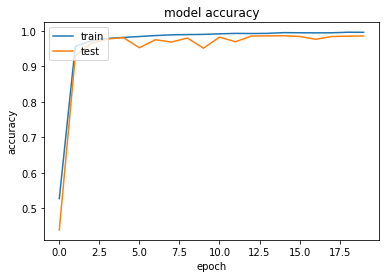

In [18]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# accuracy plot
plt.show()

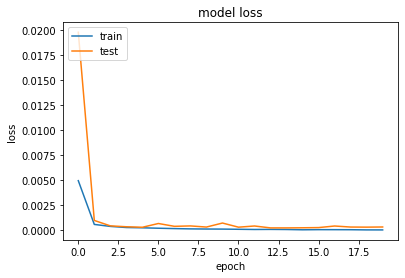

In [19]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# loss plot
plt.show()

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    
    plt.figure(figsize=(8,10))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

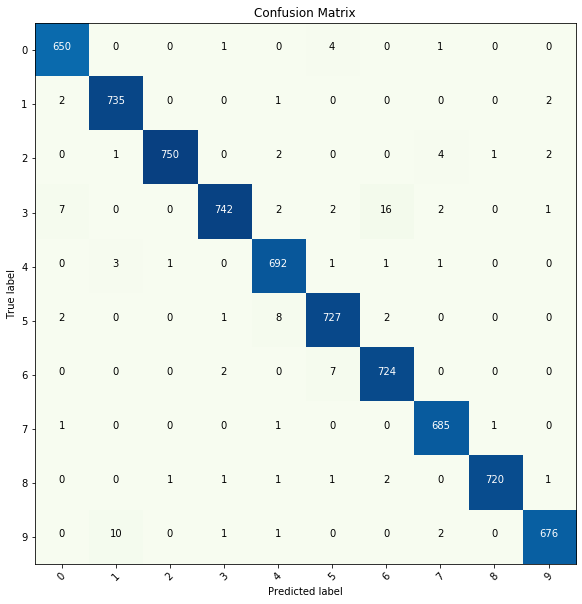

In [21]:
Y_pred_classes = np.argmax(predictions_prob, axis = 1) 

# Converting validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10), normalize=False,
                      title='Confusion Matrix')

In [22]:
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, r2_score, roc_curve, roc_auc_score, auc, recall_score, precision_score, precision_recall_fscore_support

accS = accuracy_score(Y_true, Y_pred_classes, normalize=True)
prs = precision_score(Y_true, Y_pred_classes, average='micro')
rcl = recall_score(Y_true, Y_pred_classes, average='micro')
f1 = f1_score(Y_true, Y_pred_classes, average='macro')
rmse = mean_squared_error(Y_true, Y_pred_classes, sample_weight=None, multioutput='uniform_average')

accS, prs, rcl, f1, rmse

(0.9855655794587093,
 0.9855655794587093,
 0.9855655794587093,
 0.985623576448137,
 0.25287994448299794)

In [23]:
# Additional test data
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [24]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

X_tshow_all=X_test_all
X_tshow_all.shape

(17626, 32, 32)

In [25]:
# normalization -> range 0-1
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')
X_test_all=X_test_all/255

In [26]:
# prediction
predictions_prob=model.predict(X_test_all)

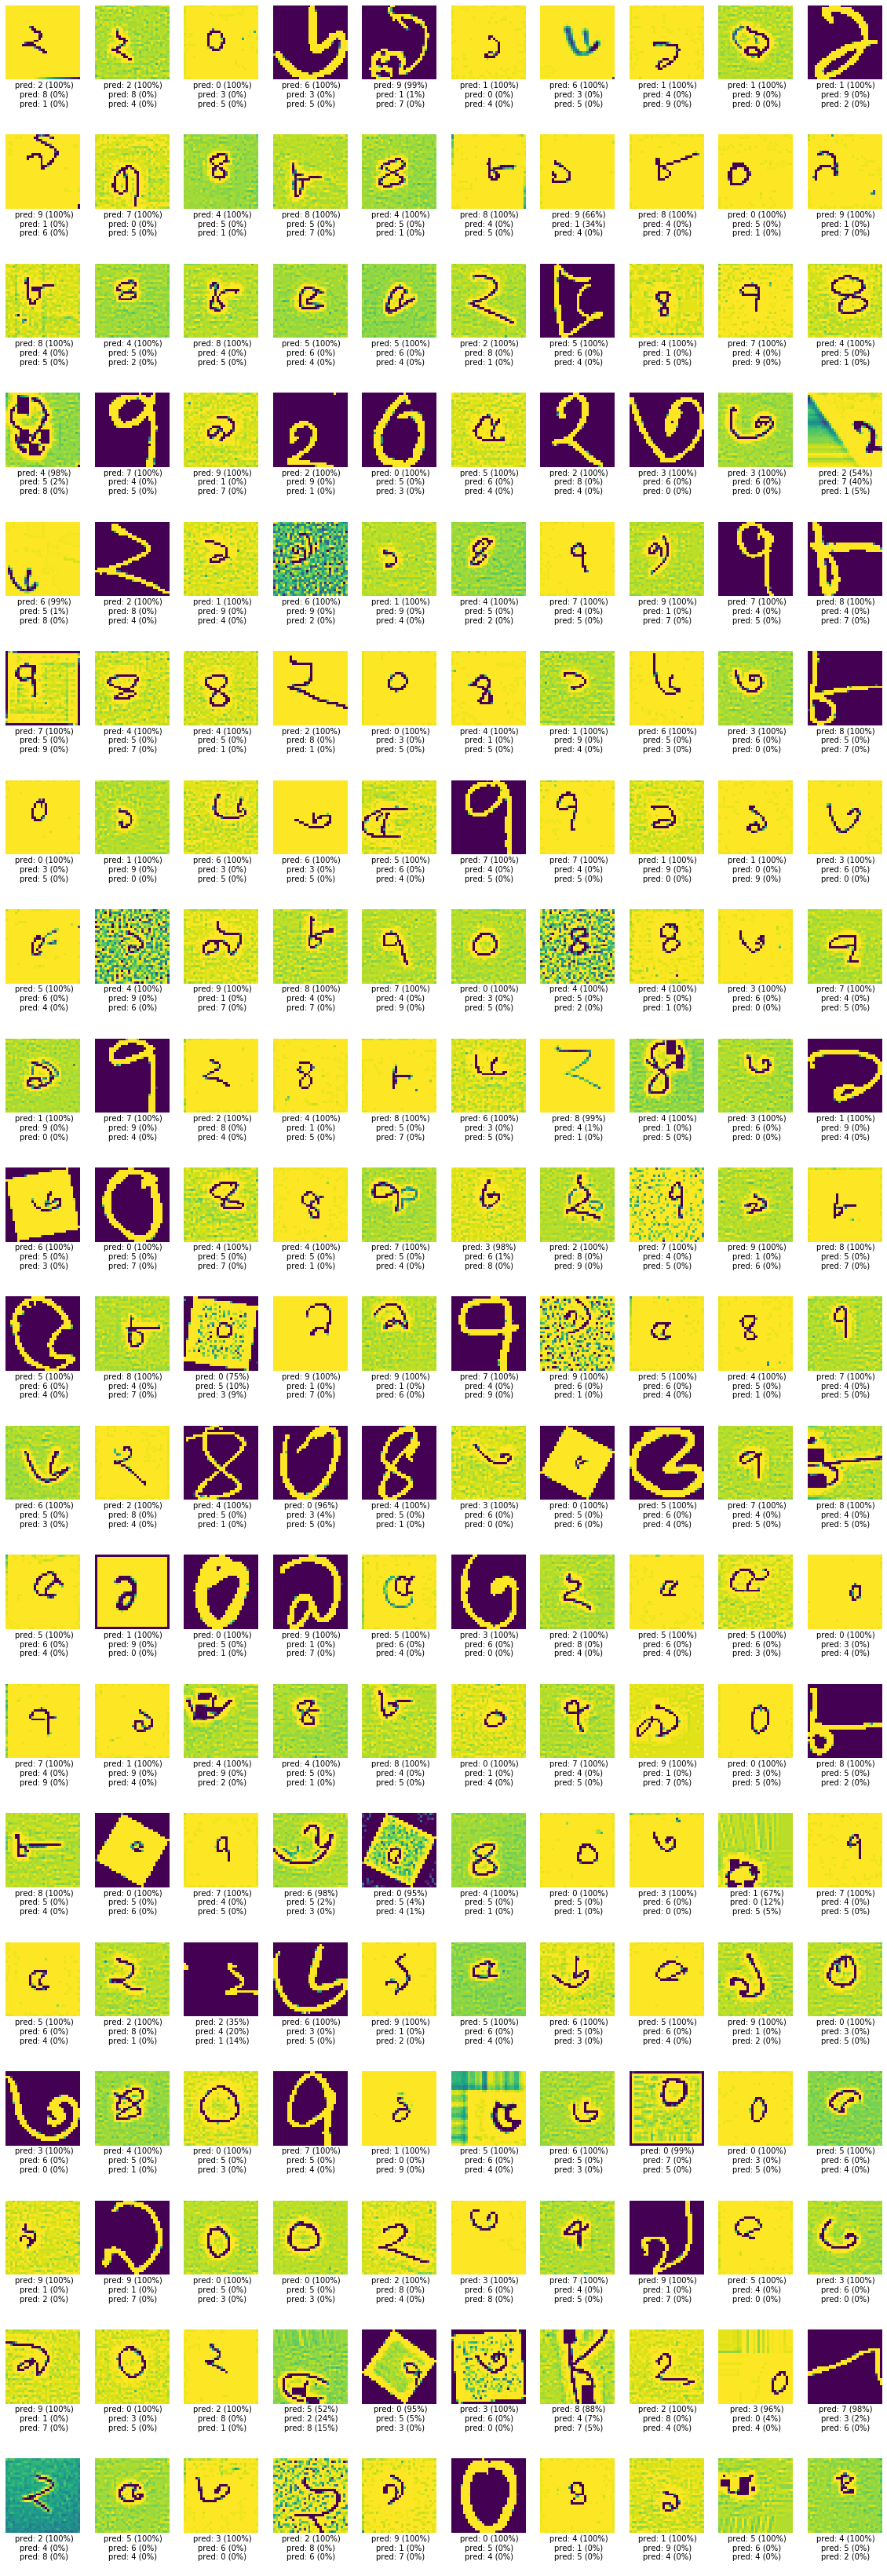

In [27]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)
imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

In [28]:
# create CSV File
labels=[np.argmax(pred) for pred in predictions_prob]
keys=[get_key(path) for path in paths_test_all ]
create_submission(predictions=labels,keys=keys,path='cnnsubmission32_final.csv')
prediction = pd.read_csv('cnnsubmission32_final.csv')
prediction.head(100)

,key,label
0,a00000.png,4
1,a00001.png,9
2,a00002.png,3
3,a00003.png,0
4,a00004.png,4
...,...,...
95,a00095.png,7
96,a00096.png,3
97,a00097.png,9
98,a00098.png,6


In [29]:
end_time = time.time()
# total time of execution
print(int(end_time - start_time))

1370
